### Descrição do Problema
As transações financeiras online cresceram exponencialmente nos últimos anos, trazendo consigo o aumento de fraudes e atividades suspeitas. Fintechs, bancos digitais e plataformas de pagamento enfrentam diariamente o desafio de identificar e bloquear transações fraudulentas em tempo real, sem impactar a experiência dos usuários legítimos.

Este projeto tem como objetivo desenvolver um modelo de machine learning capaz de identificar transações potencialmente fraudulentas, utilizando um conjunto de dados realista com mais de 51.000 registros. Cada transação é rotulada como fraudulenta ou legítima e acompanhada de informações relevantes como:

* Detalhes da transação: valor, tipo (saque, transferência, pagamento), horário

* Perfil do usuário: histórico de fraudes, idade da conta, número de transações recentes

* Contexto do dispositivo e localização: tipo de dispositivo usado e local da transação

* Método de pagamento utilizado

O principal desafio é ensinar o modelo a identificar padrões sutis de comportamento fraudulento, buscando o equilíbrio entre reduzir falsos positivos (evitar bloquear usuários legítimos) e aumentar a sensibilidade do modelo para capturar fraudes reais com precisão.

### Carregando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

### Carregando o conjunto de dados

In [2]:
# Carregando conjunto de dados
df = pd.read_csv('../data/Fraud Detection Dataset.csv')

# Pré-visualizando o conjunto de dados
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [3]:
# Visualizando tipos de dados
df.dtypes

Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object

In [4]:
# Conhecendo o conjunto de dados
print('Visualizando quantidade de linhas do conjunto de dados:', df.shape[0])
print('Visualizando quantidade de colunas do conjunto de dados:', df.shape[1])

Visualizando quantidade de linhas do conjunto de dados: 51000
Visualizando quantidade de colunas do conjunto de dados: 12


#### Observações

* O conjunto de dados possuí um total de 51000 linhas e 12 colunas
* O conjunto também possuí um total de 7 colunas numéricas
* O conjunto também possuí 5 colunas object

### Verificando Valores Ausentes

In [5]:
df.isnull().sum()

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64

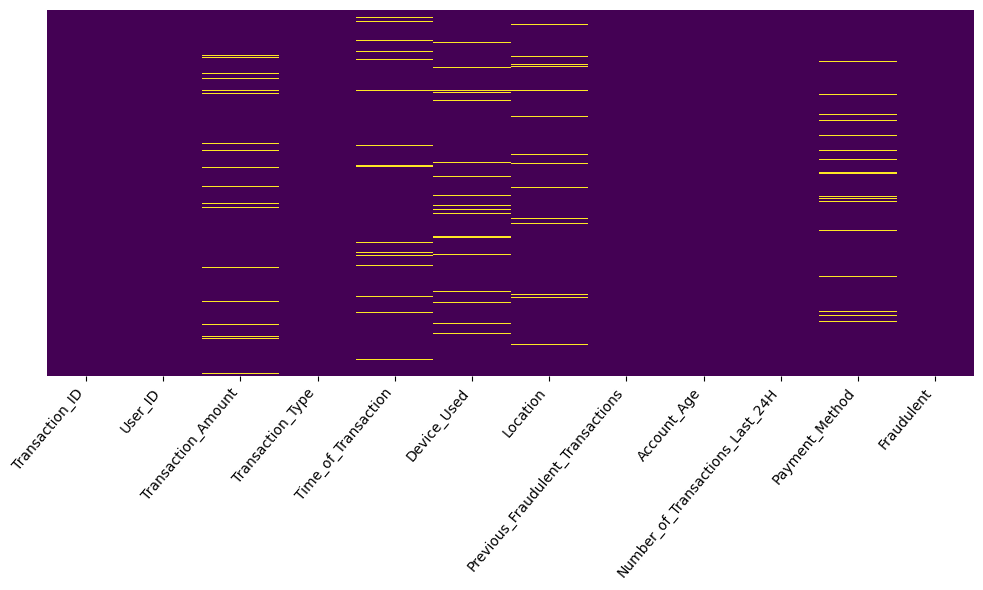

In [6]:
# Heatmap para valores ausentes

# Definindo tamanho da figura
plt.figure(figsize=(10,6))

# Plotando mapa de calor para valores ausentes
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

# Ajustando os rótulos do eixo X para espaçamento uniforme
plt.xticks(rotation = 50, ha= 'right')
plt.tight_layout()

# Exibindo gráfico
plt.show()

In [7]:
# Checando os percentuais de valores ausentes
print(df['Transaction_Amount'].isnull().sum()/df.shape[0]*100)
print(df['Time_of_Transaction'].isnull().sum()/df.shape[0]*100)
print(df['Device_Used'].isnull().sum()/df.shape[0]*100)
print(df['Location'].isnull().sum()/df.shape[0]*100)
print(df['Payment_Method'].isnull().sum()/df.shape[0]*100)

4.941176470588235
5.003921568627451
4.849019607843137
4.9941176470588236
4.841176470588236


#### Observações

* O dataframe possuí 5 colunas com valores ausentes 
* Sendo 3 colunas categóricas(Device_Used, Location, Payment_Method) e 2 numéricas(Time_of_Transaction, Transaction_Amount)
* Como não houve uma ausêcia muito grande dos dados e são dados de registros não exclusivos farei o tratamento desses valores ausentes para as variáveis categóricas(Device_Used, Location, Payment_Method) usarei a moda e para a variável numérica Time_of_Transaction a moda e Transaction_Amount a mediana

In [8]:
# Preenchendo valores ausentes de Transaction_Amount com a mediana
df['Transaction_Amount'] = df['Transaction_Amount'].fillna(df['Transaction_Amount'].median())
# Preenchendo valores ausentes de Time_of_Transaction com a moda
df['Time_of_Transaction'] = df['Time_of_Transaction'].fillna(df['Time_of_Transaction'].mode()[0])
# Preenchendo valores ausentes das colunas categóricas com a moda
for col in ['Device_Used', 'Location', 'Payment_Method']:
    df[col] = df[col].fillna(df[col].mode()[0])


In [9]:
df.isnull().sum()

Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64

### Checando a quantidade de valores únicos no dataframe

In [10]:
df.nunique()

Transaction_ID                      50000
User_ID                              4000
Transaction_Amount                  44822
Transaction_Type                        5
Time_of_Transaction                    24
Device_Used                             4
Location                                8
Previous_Fraudulent_Transactions        5
Account_Age                           119
Number_of_Transactions_Last_24H        14
Payment_Method                          5
Fraudulent                              2
dtype: int64

#### Observações

* O Conjunto de dados possuí um total 51000 linhas, mas só existe apenas 50000 registro únicos na coluna Transaction_ID
* Isso mostra que o conjunto pode possuir algumas duplicatas

#### Verficando duplicatas

In [11]:
# Verificando duplicatas
df.duplicated().sum()

np.int64(881)

In [12]:
df[df['Transaction_ID'].duplicated()].head(10)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
50000,T33554,2669,2425.71,Bank Transfer,14.0,Tablet,Seattle,2,40,7,UPI,0
50001,T9428,1001,2448.53,Bank Transfer,19.0,Mobile,San Francisco,4,7,3,UPI,0
50002,T200,3790,4429.89,ATM Withdrawal,17.0,Desktop,Miami,1,39,6,UPI,1
50003,T12448,1743,108.00,ATM Withdrawal,15.0,Tablet,Los Angeles,3,67,9,Credit Card,0
50004,T39490,4329,2320.30,ATM Withdrawal,4.0,Desktop,Los Angeles,3,12,10,UPI,0
50005,T42725,3157,120.46,Bill Payment,18.0,Tablet,Seattle,4,41,3,Net Banking,0
50006,T10823,4681,2076.32,ATM Withdrawal,0.0,Desktop,Los Angeles,3,79,2,UPI,0
50007,T49499,4979,2676.53,POS Payment,6.0,Mobile,Miami,2,40,5,Invalid Method,0
50008,T4145,4087,3874.84,Bill Payment,3.0,Mobile,Chicago,1,81,8,UPI,0
50009,T36959,4877,1722.93,POS Payment,20.0,Desktop,New York,3,60,6,Credit Card,0


In [13]:
df[df['Transaction_ID'].duplicated()].tail(20)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
50980,T3468,3176,2225.91,Online Purchase,16.0,Mobile,Seattle,1,103,9,Net Banking,1
50981,T15074,3212,819.70,Bank Transfer,20.0,Tablet,Boston,0,67,4,Credit Card,1
50982,T48706,2778,3835.20,Bill Payment,5.0,Desktop,Houston,1,113,9,UPI,0
50983,T13610,2533,1006.33,Bank Transfer,4.0,Mobile,New York,2,23,11,UPI,0
50984,T18786,4634,3309.67,POS Payment,10.0,Desktop,San Francisco,3,106,4,Net Banking,0
50985,T39758,2029,544.53,Bank Transfer,14.0,Unknown Device,Chicago,4,59,12,Debit Card,0
50986,T24217,1816,335.23,POS Payment,13.0,Tablet,Houston,2,101,5,UPI,0
50987,T33986,2365,4232.39,ATM Withdrawal,11.0,Desktop,Miami,1,2,9,Credit Card,0
50988,T11626,4614,1909.03,Bank Transfer,13.0,Desktop,San Francisco,4,105,14,Credit Card,0
50989,T12137,1617,2278.46,Bank Transfer,10.0,Desktop,Boston,4,45,11,UPI,0


In [14]:
df.loc[df['Transaction_ID'] == 'T39758']

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
39757,T39758,2029,544.53,Bank Transfer,14.0,Tablet,Chicago,4,59,12,Debit Card,0
50985,T39758,2029,544.53,Bank Transfer,14.0,Unknown Device,Chicago,4,59,12,Debit Card,0


#### Observações

* Após a verificação confirmei que há duplicidade e estarei mantendo a primeira ocorrência e removendo a segunda

In [15]:
# Removendo duplicatas
df = df.drop_duplicates(subset='Transaction_ID', keep='first')

In [16]:
# Verificando duplicatas
df.duplicated().sum()

np.int64(0)

In [17]:
print('Visualizando quantidade de linhas do conjunto de dados:', df.shape[0])

Visualizando quantidade de linhas do conjunto de dados: 50000


In [18]:
# verificando colunas com tipo de object
df.select_dtypes(include='object').columns

Index(['Transaction_ID', 'Transaction_Type', 'Device_Used', 'Location',
       'Payment_Method'],
      dtype='object')

In [19]:
# verificando valores únicos de algumas colunas

col = ['Device_Used', 'Transaction_Type', 'Payment_Method']

for i in col:
  print(f'{df[i].value_counts()}')

Device_Used
Desktop           17934
Mobile            15285
Tablet            15281
Unknown Device     1500
Name: count, dtype: int64
Transaction_Type
Bill Payment       10130
Bank Transfer      10093
ATM Withdrawal      9958
POS Payment         9932
Online Purchase     9887
Name: count, dtype: int64
Payment_Method
UPI               14070
Debit Card        11594
Net Banking       11437
Credit Card       11403
Invalid Method     1496
Name: count, dtype: int64


### Análise Exploratória de Dados(EDA)

#### Objetivo

* O principal objetivo é obter ideias sobre os diferentes atributos das transações
* Obter uma visão geral da distribuição dos dados.
* Obter uma visão geral do relacionamento entre os atributos.
* Obter uma visão geral do relacionamento entre os atributos e a variável alvo [Fraudulent].

##### Checando a distribuição de [Payment_Method, Device_Used e Transaction_Type]

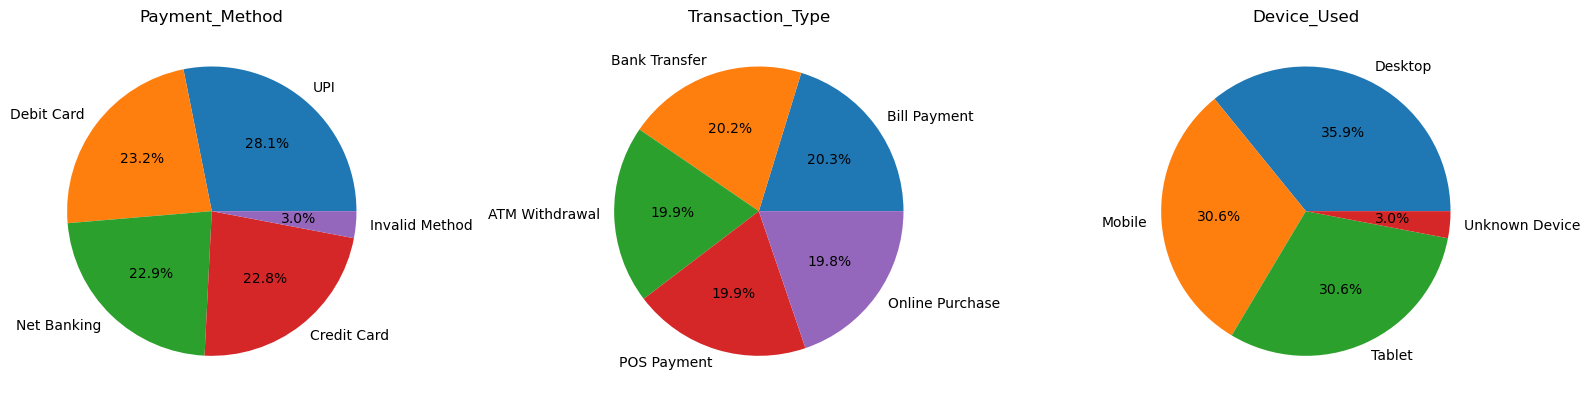

In [20]:
dist_col = ['Payment_Method','Transaction_Type','Device_Used']

plt.figure(figsize=(16,9))
for i in range(len(dist_col)):
  plt.subplot(1, 3, i+1)
  plt.title(dist_col[i])
  
  counts = df[dist_col[i]].value_counts()
  plt.pie(counts, labels=counts.index, autopct='%1.1f%%')

plt.tight_layout()
plt.show()

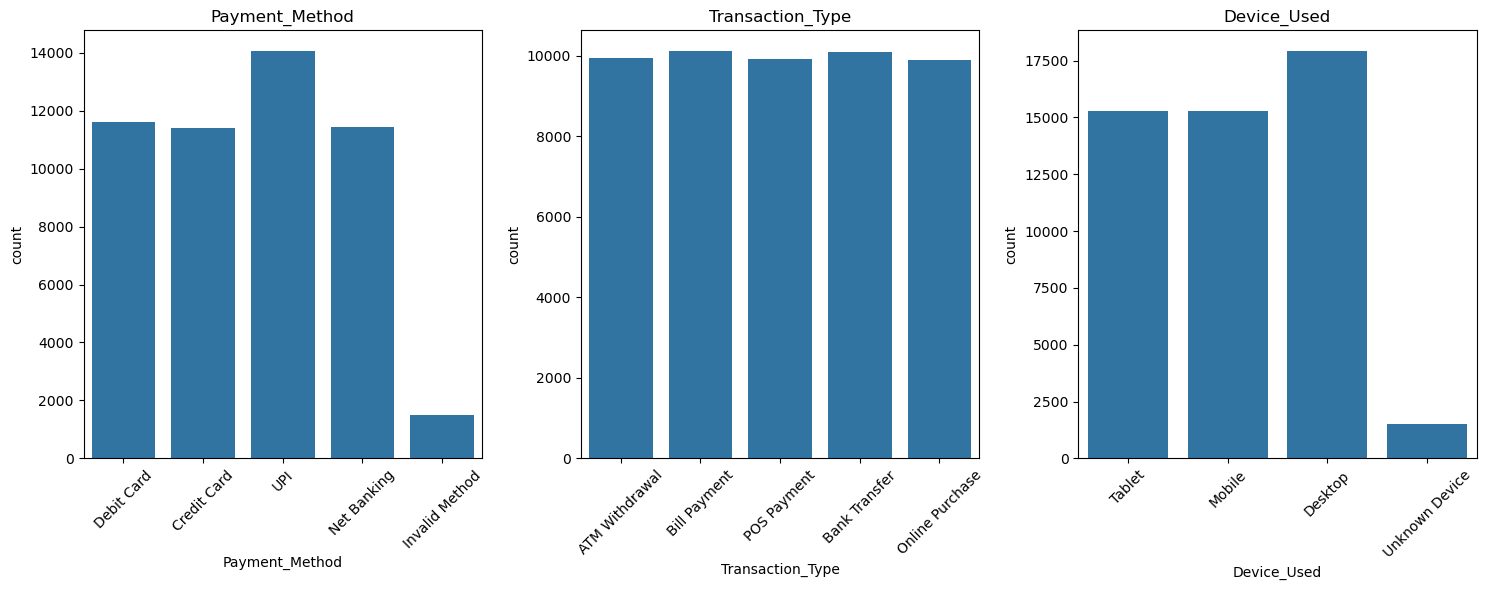

In [21]:
dist_col_2 = ['Payment_Method','Transaction_Type','Device_Used']

plt.figure(figsize=(15, 6))
for i in range(len(dist_col_2)):
  plt.subplot(1, 3, i+1)
  plt.title(dist_col_2[i])
  sns.countplot(data = df, x = df[dist_col_2[i]])
  plt.xticks(rotation = 45)
  
plt.tight_layout()
plt.show()


#### Observações

* UPI é o tipo de pagamento mais realizado
* Os tipos de transações estão bem equilibrados sendo o Bill payment 0,1% superior em relação ao segundo tipo
* O dispositivo mais utilizado é o Desktop

In [22]:
# Verificando contagem de registros de transações fraudulentas
df['Fraudulent'].value_counts()

Fraudulent
0    47540
1     2460
Name: count, dtype: int64

### Correlação

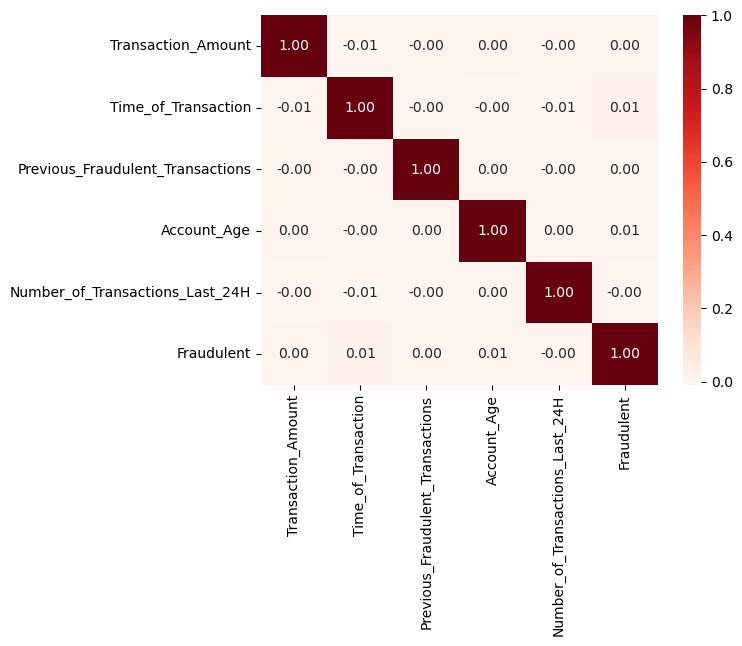

In [23]:
sns.heatmap(df[['Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H', 'Fraudulent']].corr(), annot=True, cmap='Reds', fmt='.2f')

plt.show()

#### Observações

* Não há uma correlçao muito forte entre as variáveis numéricas

### Label Encoder

In [24]:
df = df.drop(columns=['Transaction_ID', 'User_ID', 'Time_of_Transaction'])

In [ ]:
# Filtrando colunas que precisam de Label Encoder
col = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']

labelencoder =  LabelEncoder()
label_mappings = {}

for i in col:
    df[i] =labelencoder.fit_transform(df[i])
    mapping = {label: code for code, label in enumerate(labelencoder.classes_)}
    label_mappings[i] = mapping
    
for col_name, mapping in label_mappings.items():
    print(f"Column: {col_name}")
    for label, code in mapping.items():
        print(f"{label} -> {code}")
    print()


Column: Transaction_Type
ATM Withdrawal -> 0
Bank Transfer -> 1
Bill Payment -> 2
Online Purchase -> 3
POS Payment -> 4

Column: Device_Used
Desktop -> 0
Mobile -> 1
Tablet -> 2
Unknown Device -> 3

Column: Location
Boston -> 0
Chicago -> 1
Houston -> 2
Los Angeles -> 3
Miami -> 4
New York -> 5
San Francisco -> 6
Seattle -> 7

Column: Payment_Method
Credit Card -> 0
Debit Card -> 1
Invalid Method -> 2
Net Banking -> 3
UPI -> 4



### Verificando Multicolinearidade

In [26]:
# Verificando a existência de multicolinearidade

col = df.drop(['Fraudulent'], axis=1)

factor = pd.DataFrame(columns=['VIF', 'Features'])
factor['Features'] = col.columns
factor['VIF'] = [variance_inflation_factor(col.values, i) for i in range(col.shape[1])]

factor

,VIF,Features
0,1.334168,Transaction_Amount
1,2.637099,Transaction_Type
2,2.125903,Device_Used
3,2.628315,Location
4,2.625335,Previous_Fraudulent_Transactions
5,3.330186,Account_Age
6,3.561122,Number_of_Transactions_Last_24H
7,2.480892,Payment_Method


#### Observações

* Não há um VIF muito alta entre todas as colunas
* Portanto, não removerei nenhuma coluna